# On the Use of Machine Learning Algorithms to Evaluate the Corrosion Behavior of Stainless Steels in Lactic Acid

In order to classify the corrosion behavior of stainless steel alloys in the lactic acid solution, following steps are considered according to the attached paper.

Firstly, the necessary libraries are imported.


In [21]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.tree        
import sklearn.metrics     
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets
import scipy
import scipy.stats
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, roc_auc_score
from scipy import interp
import sklearn.ensemble
import sklearn.cluster
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
import random

## Step 1: Loading the Data

After preprocessing steps explained elaborately in the paper (Section 2.1), the data will be loaded by running the below cell:

In [22]:
#Loading the input data

Data=pd.read_csv('Final_data.csv')
print(Data.head())

      C   Mn   Si      P     S    Cr   Mo   Ni    N   Ti  Nb and Ta   Al  \
0  0.15  2.0  1.0  0.045  0.03  16.0  0.0  6.0  0.0  0.0          0  0.0   
1  0.15  2.0  1.0  0.045  0.03  16.0  0.0  6.0  0.0  0.0          0  0.0   
2  0.15  2.0  1.0  0.045  0.03  16.0  0.0  6.0  0.0  0.0          0  0.0   
3  0.15  2.0  1.0  0.045  0.03  16.0  0.0  6.0  0.0  0.0          0  0.0   
4  0.15  2.0  1.0  0.045  0.03  16.0  0.0  6.0  0.0  0.0          0  0.0   

   Fe balance (%)  Lactic acid concentration  Temperature      Label  
0           74.78                        1.5           20  Resistant  
1           74.78                        1.5          122  Resistant  
2           74.78                       10.0           20  Resistant  
3           74.78                       10.0          122       Good  
4           74.78                       80.0           20  Resistant  


In [23]:
#Counting the number of classes our target variable have
Data.groupby('Label').count()

,C,Mn,Si,P,S,Cr,Mo,Ni,N,Ti,Nb and Ta,Al,Fe balance (%),Lactic acid concentration,Temperature
Label,,,,,,,,,,,,,,,
Good,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58
Poor,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22
Questionable,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
Resistant,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95


In [24]:
#Transform the labels from object (good, poor, Questionable, resistant) to int64 (0,1,2,3)readable by machine for calculating ROC curve

def label_encoder(y):
    le = LabelEncoder()
    Data[y] = le.fit_transform(Data[y])
label_list = ["Label"]
for l in label_list:
    label_encoder(l)
Data

,C,Mn,Si,P,S,Cr,Mo,Ni,N,Ti,Nb and Ta,Al,Fe balance (%),Lactic acid concentration,Temperature,Label
0,0.15,2.0,1.0,0.045,0.03,16.0,0.0,6.0,0.00,0.0,0,0.0,74.78,1.5,20,3
1,0.15,2.0,1.0,0.045,0.03,16.0,0.0,6.0,0.00,0.0,0,0.0,74.78,1.5,122,3
2,0.15,2.0,1.0,0.045,0.03,16.0,0.0,6.0,0.00,0.0,0,0.0,74.78,10.0,20,3
3,0.15,2.0,1.0,0.045,0.03,16.0,0.0,6.0,0.00,0.0,0,0.0,74.78,10.0,122,0
4,0.15,2.0,1.0,0.045,0.03,16.0,0.0,6.0,0.00,0.0,0,0.0,74.78,80.0,20,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,0.03,2.0,1.0,0.045,0.03,21.0,2.5,4.5,0.08,0.0,0,0.0,68.82,10.0,122,3
194,0.03,2.0,1.0,0.045,0.03,21.0,2.5,4.5,0.08,0.0,0,0.0,68.82,80.0,20,3
195,0.03,2.0,1.0,0.045,0.03,21.0,2.5,4.5,0.08,0.0,0,0.0,68.82,80.0,122,0
196,0.03,2.0,1.0,0.045,0.03,21.0,2.5,4.5,0.08,0.0,0,0.0,68.82,100.0,20,3


In [25]:
#Split the data to the training data (80%) and testing data (20%)

X=Data.drop(["Label"],axis=1)
y=Data["Label"]
np.random.seed(0)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True)

## Step 2: Train a decision tree model and accuracy calculation

In this section, the DT model is fitted, and the accuracy of the model is calculated. To improve the accuracy of the model hyperparameter search is also applied. The performance of the model is also analyzed by confusion matrix.

Decision Tree Accuracy:
 Train accuracy 98.73%
 Test accuracy  90.00%


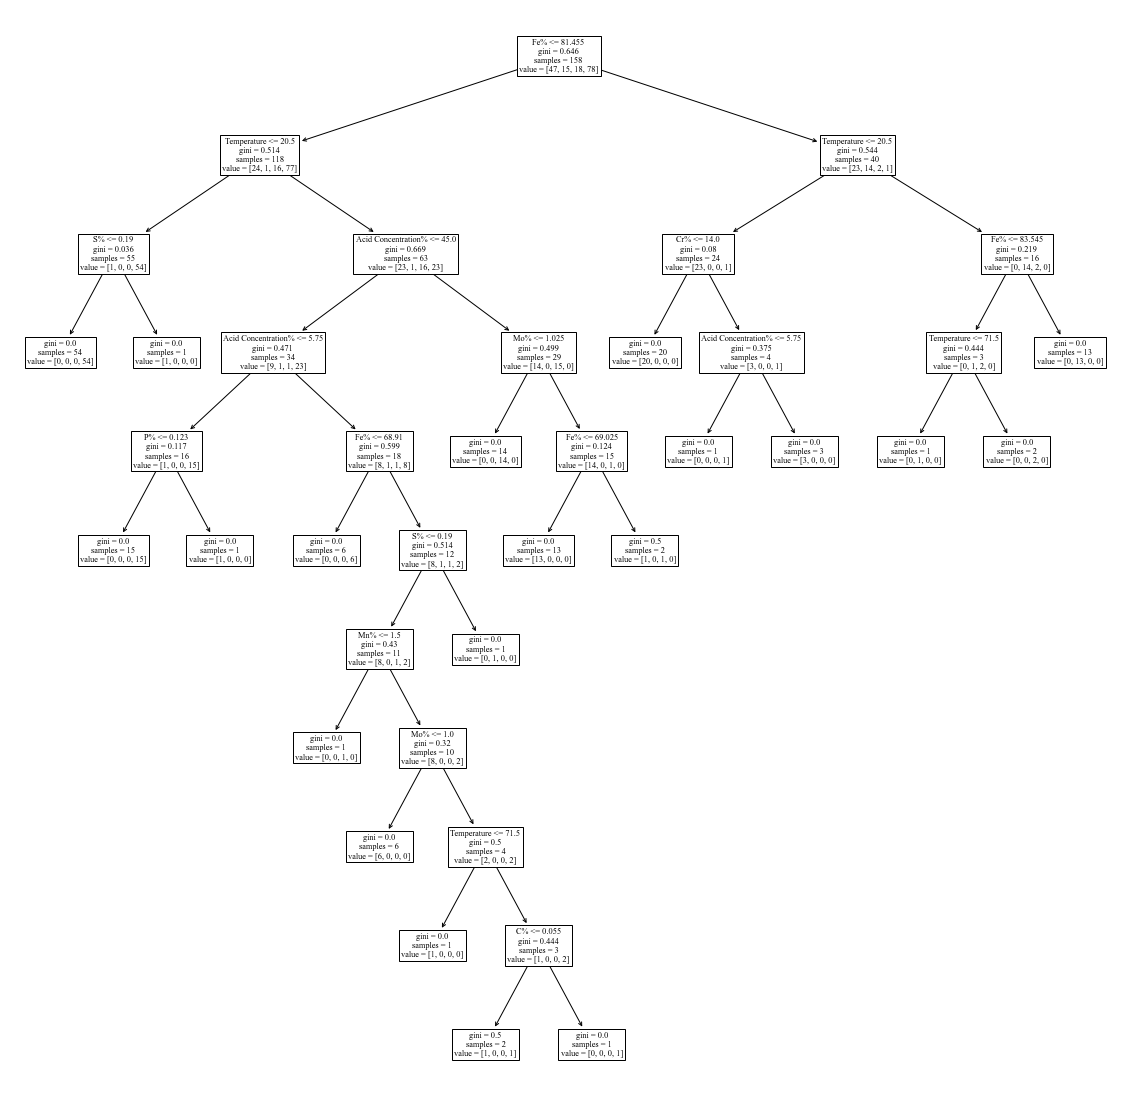

In [26]:
#Fitting DT model
decision_tree_model=sklearn.tree.DecisionTreeClassifier(random_state=0).fit(X_train,y_train)

#accuracy calculation
train_accuracy=sklearn.metrics.accuracy_score(y_train, decision_tree_model.predict(X_train))*100
test_accuracy=sklearn.metrics.accuracy_score(y_test, decision_tree_model.predict(X_test))*100

#printing the accuracy
print('Decision Tree Accuracy:')
print(' Train accuracy %.2f%%'%train_accuracy)
print(' Test accuracy  %.2f%%'%test_accuracy)

#Plotting the decision tree
plt.figure(figsize=(20,20))
sklearn.tree.plot_tree(decision_tree_model,feature_names=['C%', 'Mn%', 'Si%','P%','S%','Cr%','Mo%','Ni%','N%'
                                             ,'Ti%','Nb/Ta%','Al%','Fe%','Acid Concentration%','Temperature']);



In [27]:
#hyperparameter search for decision tree

param_dist={"criterion":["gini","entropy"],
           "max_depth":[1,2,3,4,5,6,7,8,9,10,11,12,None]}
clf=sklearn.tree.DecisionTreeClassifier()
grid=GridSearchCV(clf,param_grid=param_dist, cv=10, n_jobs=-1,)
random.seed(0)
grid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       None]})

In [28]:
#finding the best estimator
grid.best_estimator_

DecisionTreeClassifier(max_depth=5)

In [29]:
#finding the best score
grid.best_score_

0.9245833333333333

In [30]:
#finding the best parameter
grid.best_params_

{'criterion': 'gini', 'max_depth': 5}

Decision Tree Accuracy:
 Train accuracy 96.84%
 Test accuracy  92.50%


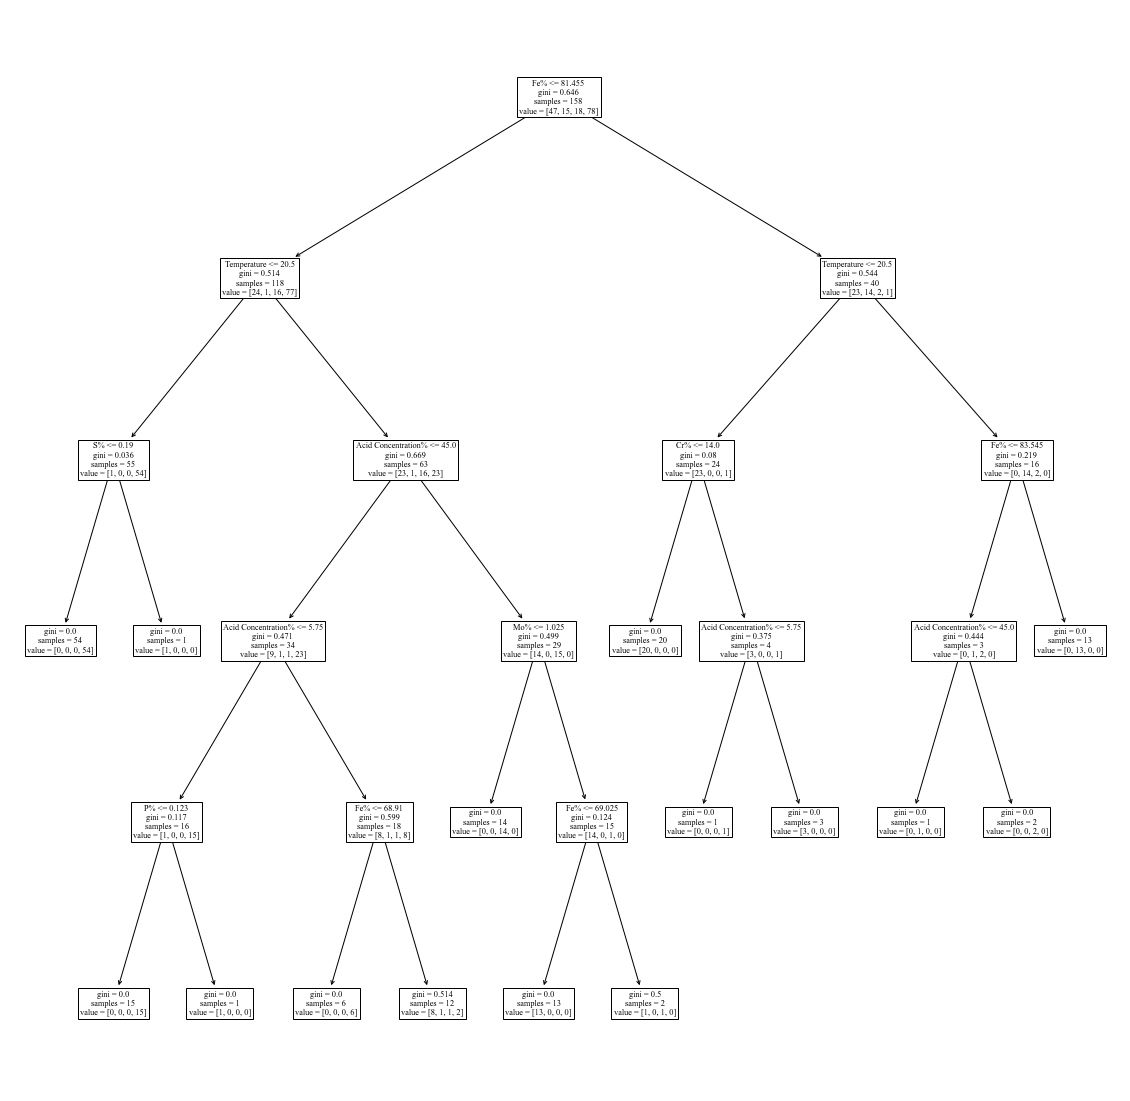

In [31]:
decision_tree_model=sklearn.tree.DecisionTreeClassifier(random_state=0, max_depth=5, criterion="gini").fit(X_train,y_train)

#accuracy calculation
train_accuracy=sklearn.metrics.accuracy_score(y_train, decision_tree_model.predict(X_train))*100
test_accuracy=sklearn.metrics.accuracy_score(y_test, decision_tree_model.predict(X_test))*100

#printing the accuracy
print('Decision Tree Accuracy:')
print(' Train accuracy %.2f%%'%train_accuracy)
print(' Test accuracy  %.2f%%'%test_accuracy)

#Plotting the decision tree
plt.figure(figsize=(20,20))
sklearn.tree.plot_tree(decision_tree_model,feature_names=['C%', 'Mn%', 'Si%','P%','S%','Cr%','Mo%','Ni%','N%'
                                             ,'Ti%','Nb/Ta%','Al%','Fe%','Acid Concentration%','Temperature']);




/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


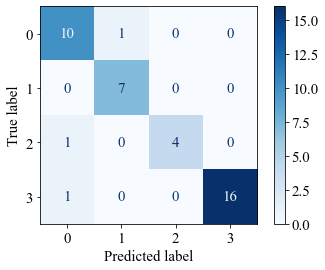

In [38]:
#Confusion matrix for DT

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 15})
plot_confusion_matrix(decision_tree_model, X_test, y_test, cmap='Blues')  
plt.show()

In [39]:
#K-fold Cross Validation

accuracy=np.array([])
for i in range(0,10):
    D_T=sklearn.tree.DecisionTreeClassifier(random_state=0, max_depth=10) 
    scores=sklearn.model_selection.cross_val_score(D_T,X, y,cv=i+2) 
    mean=np.mean(scores)
    accuracy=np.hstack((accuracy,mean*100))
    print('held-out accuracy (%d-fold): %0.2f%%' %(i+2,accuracy[i]))

held-out accuracy (2-fold): 76.77%
held-out accuracy (3-fold): 72.73%
held-out accuracy (4-fold): 79.73%
held-out accuracy (5-fold): 84.28%
held-out accuracy (6-fold): 87.37%
held-out accuracy (7-fold): 86.93%
held-out accuracy (8-fold): 86.79%
held-out accuracy (9-fold): 88.89%
held-out accuracy (10-fold): 88.29%
held-out accuracy (11-fold): 87.37%


## Step 3: Train SVM, accuracy calculation, and hyperparameter search

In this section, the SVM model with the defult hyperparameter values is fitted, and the accuracy of the model is calculated. Based on the initial accuracies and the results of the confusion matrix, we decided to tune the hyperparameters by hyperparameter search.The performance of the model is also analyzed by confusion matrix before and after hyperparameter tuning. 

In [40]:
#Fitting SVM model
svm_model=sklearn.svm.SVC(kernel='rbf').fit(X_train,y_train)

#Accuracy calculation
train_ac=sklearn.metrics.accuracy_score(y_train, svm_model.predict(X_train)) 
test_ac=sklearn.metrics.accuracy_score(y_test, svm_model.predict(X_test)) 

print('SVM model accuracy:')
print(' Train accuracy %.2f%% '%(train_ac*100)) 
print(' Test accuracy  %.2f%% '%(test_ac*100))

SVM model accuracy:
 Train accuracy 60.13% 
 Test accuracy  55.00% 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


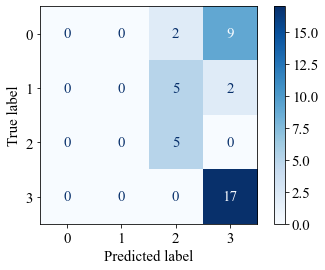

In [41]:
#Confusion matrix for SVM before hypeparameter search

plot_confusion_matrix(svm_model, X_test, y_test, cmap='Blues')  
plt.show()

In [42]:
#Draw samples from reciprocal distribution for searching hyperparameters

C=scipy.stats.reciprocal(1, 100)
gamma=scipy.stats.reciprocal(0.01, 20)
param_distributions={'C':C,'gamma':gamma}
random_search=sklearn.model_selection.RandomizedSearchCV(svm_model, param_distributions,n_iter=20, cv=3, verbose=1, random_state=0).fit(X_train,y_train)
random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


SVC(C=1.386986124535732, gamma=0.019391724470856554)

In [43]:
#Accuracy calculation baesd on the hyperparameter search results (C,gamma) 

rs_train_ac=sklearn.metrics.accuracy_score(y_train, random_search.predict(X_train)) 
rs_test_ac=sklearn.metrics.accuracy_score(y_test, random_search.predict(X_test)) 

print('Random search:')
print(' Train accuracy: %.2f%% '%(rs_train_ac*100)) 
print(' Test accuracy:  %.2f%% '%(rs_test_ac*100))

Random search:
 Train accuracy: 93.04% 
 Test accuracy:  87.50% 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


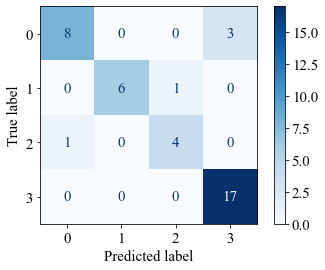

In [44]:
#Confusion matrix after hyperparameter tuning for SVM

plot_confusion_matrix(random_search, X_test, y_test, cmap='Blues')  
plt.show()

## Step4: Computing receiver operating characteristic 

Binarizing the classes and computing the ROC curve according to the scikit-learn code for SVM model.

/var/folders/d1/7_phhjrs5yzbb3xycn7mr4th0000gn/T/ipykernel_5762/66218607.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


<Figure size 432x288 with 0 Axes>

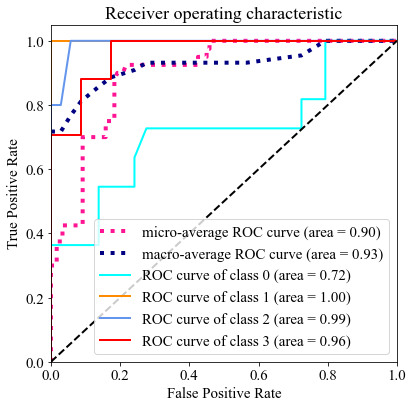

In [45]:
#Binarizing the classes in order to draw ROC for multiclassification
y_b = label_binarize(y, classes=[0, 1, 2, 3]) 
n_classes = y_b.shape[1]
np.random.seed(0)
X_train,X_test,y_b_train,y_b_test=train_test_split(X,y_b,test_size=0.2)
classifier = OneVsRestClassifier(svm.SVC(kernel='rbf', probability=True,
                                 random_state=0))
y_score=classifier.fit(X_train,y_b_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_b_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_b_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(6.2,6.2))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

## Step 5: Random forest classification

Random Forest Classifier with random_state=0 is fitted to our training data. Also, a hyperparameter search between 1 to 50 is applied to find the best n_estimators for this algorithm. The confusion matrix is also used to analyze the performance of the model.

In [46]:
accuracies_test=np.array([])

# Finding the index of best test accuracies for n_estimators between 1 to 50

for i in range(1,51):
    random_forest=sklearn.ensemble.RandomForestClassifier(random_state=0, n_estimators=i).fit(X_train,y_train)
    accuracy_test=sklearn.metrics.accuracy_score(y_test, random_forest.predict(X_test))
    accuracies_test=np.hstack((accuracies_test,accuracy_test))
index_test=np.where(accuracies_test==np.amax(accuracies_test))
print(accuracies_test) # print test accuracies of models with n_estimators between 1 to 50
print(index_test)      # print the index of the highest test accuracies

[0.8   0.8   0.85  0.85  0.8   0.8   0.8   0.875 0.875 0.875 0.85  0.825
 0.775 0.8   0.875 0.85  0.825 0.825 0.85  0.85  0.875 0.825 0.825 0.825
 0.825 0.825 0.875 0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.825
 0.825 0.825 0.825 0.825 0.825 0.825 0.825 0.825 0.825 0.825 0.825 0.825
 0.825 0.825]
(array([ 7,  8,  9, 14, 20, 26]),)


In [47]:
# Fitting random forest model with n_estimators=8 according to one of the indexes obtained in the previous cell

random_forest=sklearn.ensemble.RandomForestClassifier(random_state=0, n_estimators=8).fit(X_train,y_train)
accuracy_train=sklearn.metrics.accuracy_score(y_train, random_forest.predict(X_train))
accuracy_test=sklearn.metrics.accuracy_score(y_test, random_forest.predict(X_test))
print('Random Forest')
print(' Train accuracy: %.2f%% '%(accuracy_train*100)) 
print(' Test accuracy:  %.2f%% '%(accuracy_test*100))

Random Forest
 Train accuracy: 98.10% 
 Test accuracy:  87.50% 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


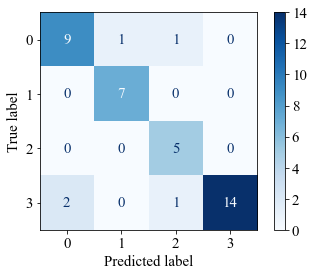

In [48]:
#Confusion matrix for RF model
plot_confusion_matrix(random_forest, X_test, y_test, cmap='Blues')  
plt.show()

## Step 6: Feature reduction 

In this step, the accuracy of each model was calculated and compared after reducing the number of features.  

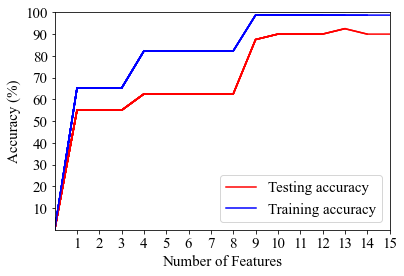

In [49]:
# Feature reduction for DT model
p=np.array([0])
test_accuracy_reduced_collection=np.array([0])
train_accuracy_reduced_collection=np.array([0])
#Select_KBest function can rank the input feature based on their importance. 
#K is the number of features that will be considered as the most influencing features
#Using a for loop, different K values are examined to see how the accuracy changes by considering different number of features
for i in range(1,16):
    fvalue_Best = SelectKBest(f_classif, k=i)
    X_kbest = fvalue_Best.fit_transform(X, y)
    np.random.seed(0)
    X_train_reduced,X_test_reduced,y_train_reduced,y_test_reduced=train_test_split(X_kbest,y,test_size=0.2,shuffle=True)
    decision_tree_model_reduced=sklearn.tree.DecisionTreeClassifier(random_state=0).fit(X_train_reduced,y_train_reduced)

#accuracy calculation

    train_accuracy_reduced=sklearn.metrics.accuracy_score(y_train_reduced, decision_tree_model_reduced.predict(X_train_reduced))*100
    test_accuracy_reduced=sklearn.metrics.accuracy_score(y_test_reduced, decision_tree_model_reduced.predict(X_test_reduced))*100
    p=np.vstack((p,np.array([i])))
    test_accuracy_reduced_collection=np.vstack((test_accuracy_reduced_collection, test_accuracy_reduced))
    train_accuracy_reduced_collection=np.vstack((train_accuracy_reduced_collection, train_accuracy_reduced))
    plt.plot(p,test_accuracy_reduced_collection, label="Testing accuracy", color="red")
    plt.plot(p,train_accuracy_reduced_collection, label="Training accuracy", color="blue")
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy (%)')
    plt.xlim([0,15])
    plt.ylim([0,100])
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
    plt.yticks([10,20,30,40,50,60,70,80,90,100])
    if i==1: plt.legend(loc="lower right")

In [50]:
# The most important features are identified for the model based on the above graph

best_decision_tree_features = SelectKBest(f_classif, k=9)
kbest = best_decision_tree_features.fit_transform(X, y)
best_features=best_decision_tree_features.get_support(indices=True)
df2=Data.iloc[:,0:]
features_df_new=df2.iloc[:,best_features]
list(features_df_new)

['C',
 'Mn',
 'Cr',
 'Mo',
 'Ni',
 'N',
 'Fe balance (%)',
 'Lactic acid concentration',
 'Temperature']

80.0


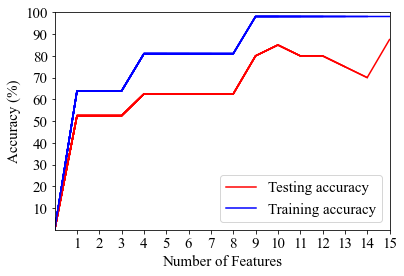

In [51]:
#feature reduction for RF model

p=np.array([0])
test_accuracy_reduced_collection=np.array([0])
train_accuracy_reduced_collection=np.array([0])
#Select_KBest function can rank the input feature based on their importance. 
#K is the number of features that will be considered as the most influencing features
#Using a for loop, different K values are examined to see how the accuracy changes by considering different number of features
for i in range(1,16):
    fvalue_Best = SelectKBest(f_classif, k=i)
    X_kbest = fvalue_Best.fit_transform(X, y)
    np.random.seed(0)
    X_train_reduced,X_test_reduced,y_train_reduced,y_test_reduced=train_test_split(X_kbest,y,test_size=0.2,shuffle=True)
    random_forest_reduced=sklearn.ensemble.RandomForestClassifier(random_state=0, n_estimators=8).fit(X_train_reduced,y_train_reduced)

    #accuracy calculation

    train_accuracy_reduced=sklearn.metrics.accuracy_score(y_train_reduced, random_forest_reduced.predict(X_train_reduced))*100
    test_accuracy_reduced=sklearn.metrics.accuracy_score(y_test_reduced, random_forest_reduced.predict(X_test_reduced))*100
    p=np.vstack((p,np.array([i])))
    test_accuracy_reduced_collection=np.vstack((test_accuracy_reduced_collection, test_accuracy_reduced))
    train_accuracy_reduced_collection=np.vstack((train_accuracy_reduced_collection, train_accuracy_reduced))
    plt.plot(p,test_accuracy_reduced_collection, label="Testing accuracy", color="red")
    plt.plot(p,train_accuracy_reduced_collection, label="Training accuracy", color="blue")
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy (%)')
    plt.xlim([0,15])
    plt.ylim([0,100])
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
    plt.yticks([10,20,30,40,50,60,70,80,90,100])
    if i==1: plt.legend(loc="lower right")
    if i==9: print(test_accuracy_reduced)



Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


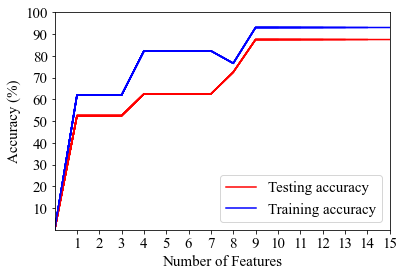

In [52]:
#feature reduction for SVM model

p=np.array([0])
test_accuracy_reduced_collection=np.array([0])
train_accuracy_reduced_collection=np.array([0])
#Select_KBest function can rank the input feature based on their importance. 
#K is the number of features that will be considered as the most influencing features
#Using a for loop, different K values are examined to see how the accuracy changes by considering different number of features
for i in range(1,16):
    fvalue_Best = SelectKBest(f_classif, k=i)
    X_kbest = fvalue_Best.fit_transform(X, y)
    np.random.seed(0)
    X_train_reduced,X_test_reduced,y_train_reduced,y_test_reduced=train_test_split(X_kbest,y,test_size=0.2,shuffle=True)
    svm_reduced=sklearn.model_selection.RandomizedSearchCV(svm_model, param_distributions,n_iter=20, cv=3, verbose=1, random_state=0).fit(X_train_reduced,y_train_reduced)

#accuracy calculation

    train_accuracy_reduced=sklearn.metrics.accuracy_score(y_train_reduced, svm_reduced.predict(X_train_reduced))*100
    test_accuracy_reduced=sklearn.metrics.accuracy_score(y_test_reduced, svm_reduced.predict(X_test_reduced))*100
    p=np.vstack((p,np.array([i])))
    test_accuracy_reduced_collection=np.vstack((test_accuracy_reduced_collection, test_accuracy_reduced))
    train_accuracy_reduced_collection=np.vstack((train_accuracy_reduced_collection, train_accuracy_reduced))
    plt.plot(p,test_accuracy_reduced_collection, label="Testing accuracy",color="red")
    plt.plot(p,train_accuracy_reduced_collection, label="Training accuracy", color="blue")
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy (%)')
    plt.xlim([0,15])
    plt.ylim([0,100])
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
    plt.yticks([10,20,30,40,50,60,70,80,90,100])
    if i==1: plt.legend(loc="lower right")
  

## Step 6: Computing receiver operating characteristic after dimension reduction

/var/folders/d1/7_phhjrs5yzbb3xycn7mr4th0000gn/T/ipykernel_2854/2033035523.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


<Figure size 432x288 with 0 Axes>

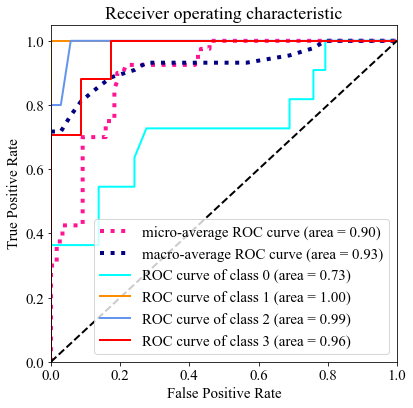

In [40]:
#Binarizing the classes in order to draw ROC for multiclassification
fvalue_Best = SelectKBest(f_classif, k=9)
X_kbest = fvalue_Best.fit_transform(X, y)
y_b = label_binarize(y, classes=[0, 1, 2, 3]) 
n_classes = y_b.shape[1]
np.random.seed(0)
X_train,X_test,y_b_train,y_b_test=train_test_split(X_kbest,y_b,test_size=0.2)
classifier = OneVsRestClassifier(svm.SVC(kernel='rbf', probability=True,
                                 random_state=0))
y_score=classifier.fit(X_train,y_b_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_b_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_b_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(6.2,6.2))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()